<a href="https://colab.research.google.com/github/Yoon0527/AIFFEL_Going_Deeper/blob/main/%5BGD_09%5D_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD-09] 물체를 분리하자! - 세그멘테이션 살펴보기
세그멘테이션(segmentation)은 픽셀 수준에서 이미지의 각 부분이 어떤 의미를 갖는 영역인지 분리해 내는 방법이다.(ex: 인물과 배경을 분리하는 인물 사진 모드)

세그멘테이션은 이미지 분할 기술이다. 이미지의 영역을 어떤 영역인지 분리해 내는 기술로 다양한 영역에서 활용되고 있다. 자율주행 카메라에 적용되어 이미지의 의미를 해석하기도 하고, 의료 이미지에서 병이 있는 영역을 판별해 내기도 한다.

이때 이미지 내에서 영역을 분리하는 접근 방식은 크게 두 가지 방식이 있다.

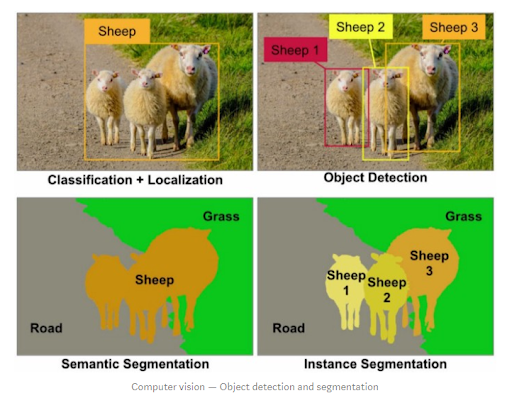

위 사진에서 좌상단 사진은 어떤 물체들이 모여 있는 영역의 위치 인식(localization)과 이 물체들이 양이라는 것을 판별(classification)하는 접근법을 보여준다. 그리고 우상단 사진은 개별 양들의 개체 하나하나의 위치를 정확히 식별하는 객체 인식(object detection)의 접근법을 보여준다.

그리고 하단의 두 사진은 세그멘테이션의 두 방식을 보여준다.
* semantic segmentation
  * 위 사진을 예시로 영역을 구분할 뿐 양들 각각을 구분하지는 않는다.
* instance segmentation
  * 각 양의 개체들의 영역을 픽셀 단위로 정확하게 구분하고 있다.

## 세그멘테이션 문제의 종류
### semantic segmentation

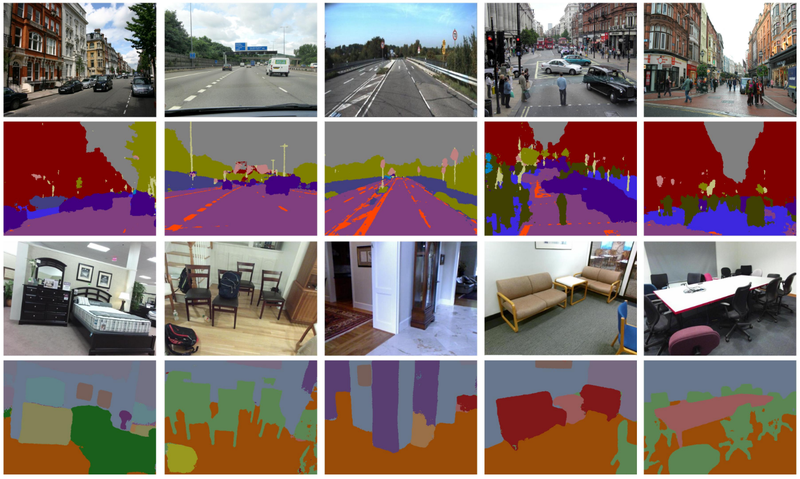

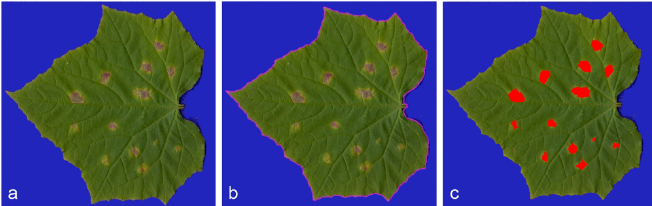

아래 모델 구조는 semantic segmentation의 대표적인 모델인 U-Net의 구조이다.

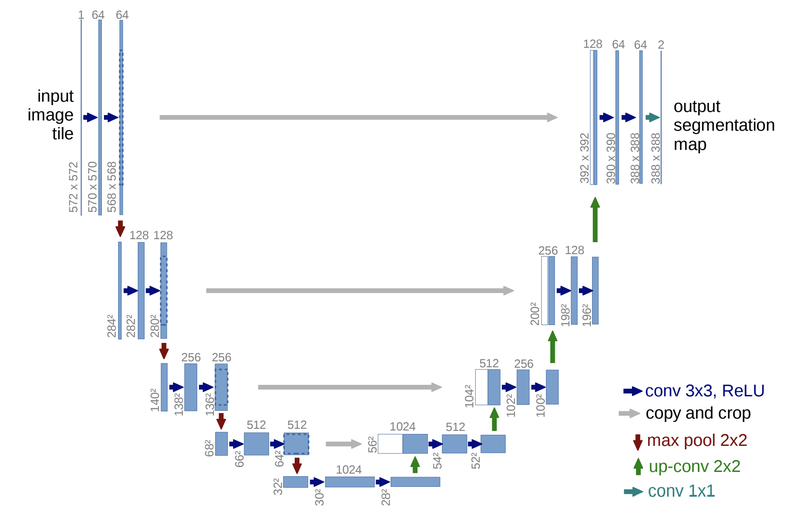

출력값이 이전에 이미지 분류나 물체 검출보다 큰 것은 segmentation을 위해 이미지의 각 픽셀에 해당하는 영역의 클래스별 정보가 필요하기 때문이다.

### instance segmentation
instance segmentation은 같은 클래스 내에서도 각 개체(instance)들을 분리하여 세그멘테이션을 수행한다.

* Mask R-CNN
  * object detection 모델로 각 개체를 구분하고 이후에 각 개체 별로 semantic segmentation을 수행해 instance segmentation을 수행한다.
  * Faster R-CNN을 계승한 것
    * Faster R-CNN의 아이디어인 Region of Interest Pooling Layer(RolPool) 개념을 개선해 정확한 segmentation에 유리하게 한 RolAlign
    * 그리고 클래스별 마스크 분리라는 단순한 두 가지 아이디어를 통해, 클래스별 object detection과 semantic segmentation을 사실상 하나의 task로 엮어낸 것으로 평가받는 중요한 모델이다.

단, RolPool 개념은 한계점이 있다.

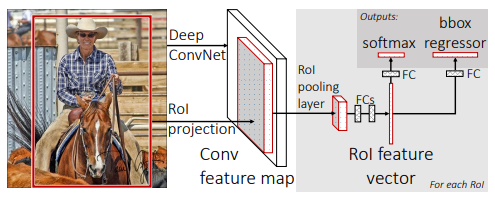

위 RolPool Layer는 다양한 Rol영역을 Pooling을 통해 동일한 큭의 Feature map으로 추출해 내는 레이어이다. 이후 이 고정 사이즈의 Feature map을 바탕으로 바운딩 박스와 object의 클래스를 추론해낸다.

이 구성은 object detection을 위해서는 크게 문제가 되지 않는다. 그러나 object 영역의 정확한 마스킹을 필요로 하는 segmentation 문제에서 문제가 되는 것은 바로 아래 그림을 보면 알 수 있는데, **RolPool 과정에서 Quantization이 필요하다는 점이다.**

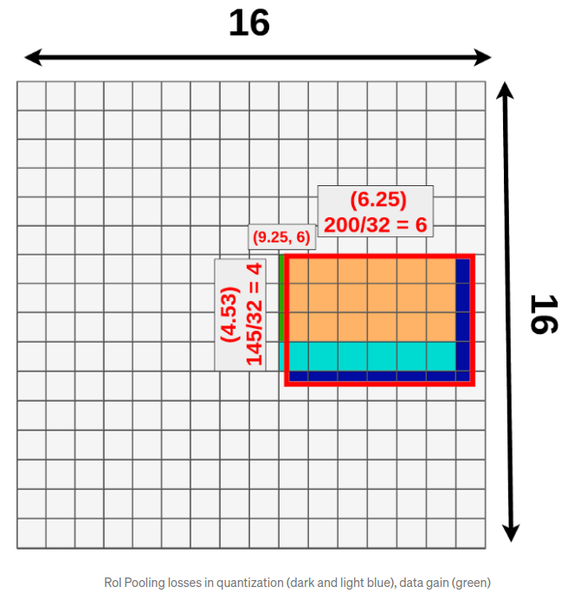

위 그림에서는 16X16으로 분할한다. 이미지에서 Rol 영역의 크기는 다양한데, 모든 Rol 영역의 가로세로 픽슬 크기가 16의 배수인 것은 아니다. 아래 그림에서 가로 200, 세로 145픽셀 짜리 Rol 영역을 16X16으로 분할된 영역 중 절반 이상이 Rol 영역에 덮이는 곳들로 끼워맞추다 보면 어쩔 수 없이 Rol 영역 밖이 포함되는 경우도 있고, 자투리 영역이 버려지는 경우도 생기게 된다. 따라서 필연적으로 semantic segmentation의 정보손실과 왜곡을 야기하게 된다.

> **Q. 위 그림에서, 가로 200, 세로 145의 RoI 영역에 대해 3X3의 RoIPool 을 적용했을 때, 정보를 잃어버리게 되는 영역의 색깔과, 불필요하게 포함되는 영역의 색깔은 각각 어떤 색인가요?**
>
> A. 3X3 RoI Pooling은 가로/세로 각각 3의 배수만큼의 영역만큼만 적용된다. 따라서 가로 6, 세로 3칸만큼만 적용이 가능하므로 진한파랑, 연한파랑색 영역은 정보를 잃어버리게 된다. 또 녹색 영역이 불필요하게 포함된다.

Mask R-CNN의 RolAlign은 Quantization하지 않고도 Rol를 처리할 고정 사이즈의 Feature map을 생성할 수 있게 아이디어를 제공한다.

아이디어의 핵심은, Rol 영역을 Pooling layer의 크기에 맞춰 등분한 후, RolPool했을 때의 quantization 영역 중 가까운 것들과의 bilinear interpolation 계산을 통해 생성해야 할 Feature map을 계산해 낸다는 점이다.

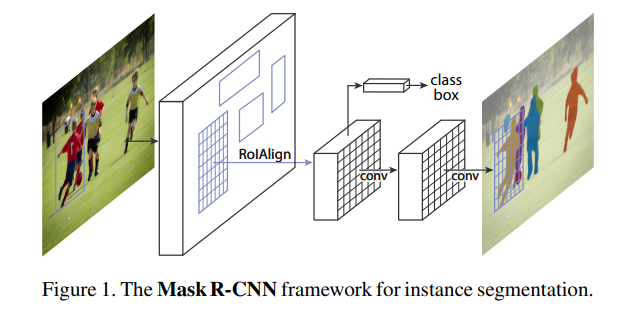

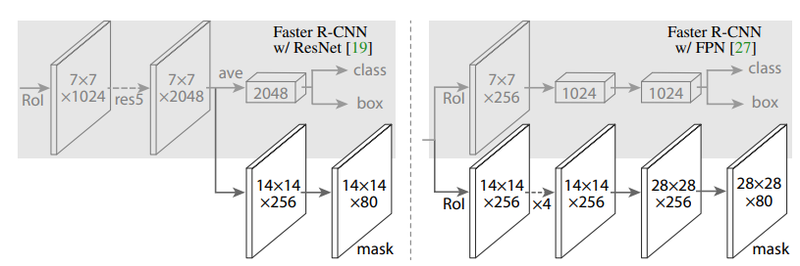

명확한 이해를 위해 본문 그대로 옮김.
> Mask R-CNN은 Faster R-CNN에서 특성 추출방식을 "RoIAlign" 방식으로 개선을 하고 세그멘테이션을 더한 방식입니다. 아래 Faster R-CNN과 비교한 구조도를 보면 U-Net처럼 피처 맵(feature map)의 크기를 키워 마스크(mask)를 생성해 내는 부분을 통해 인스턴스에 해당하는 영역, 즉 인스턴스 맵을 추론합니다. Mask R-CNN은 클래스에 따른 마스크를 예측할 때, 여러 가지 태스크를 한 모델로 학습하여 물체 검출의 성능을 높입니다.
>
> 아래 그림을 보시면 Bounding box regression을 하는 Bbox head와 마스크를 예측하는 Mask Head의 두 갈래로 나뉘는 것을 볼 수 있는데요. Mask map의 경우 시맨틱 세그멘테이션과 달리 상대적으로 작은 28x28의 특성 맵 크기를 갖습니다. RoIAlign을 통해 줄어든 특성에서 마스크를 예측하기 때문에 사용하려는 목적에 따라서 정확한 마스크를 얻으려는 경우에는 부적합할 수 있습니다.

## 주요 세그멘테이션 모델 (1) FCN
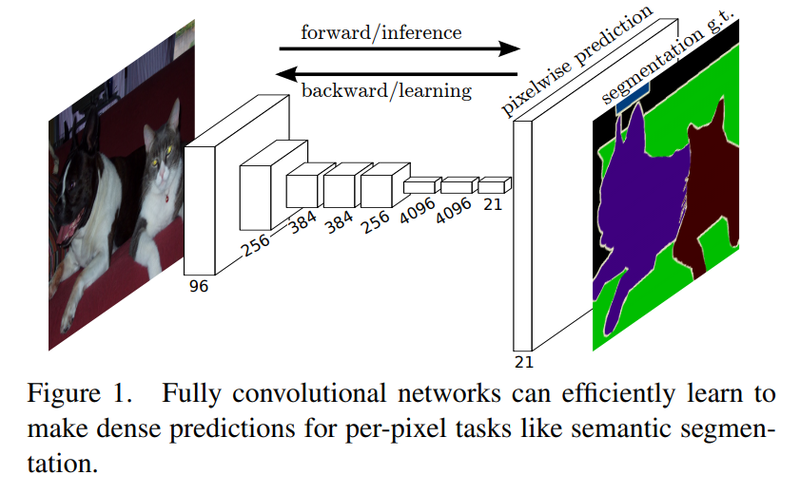

FCN은 AlexNet, VGG-16 등의 모델을 segmentation에 맞게 변형한 모델이다. 기본적인 VGG 모델은 이미지의 특성을 추출하기 위한 네트워크의 뒷단에 fully connected layer를 붙여서 계산한 클래스별 확률을 바탕으로 이미지 분류를 수행한다. FCN에서는 세그멘테이션을 하기 위해서 네트워크 뒷단에 fully connected layer대신 CNN을 분여준다.

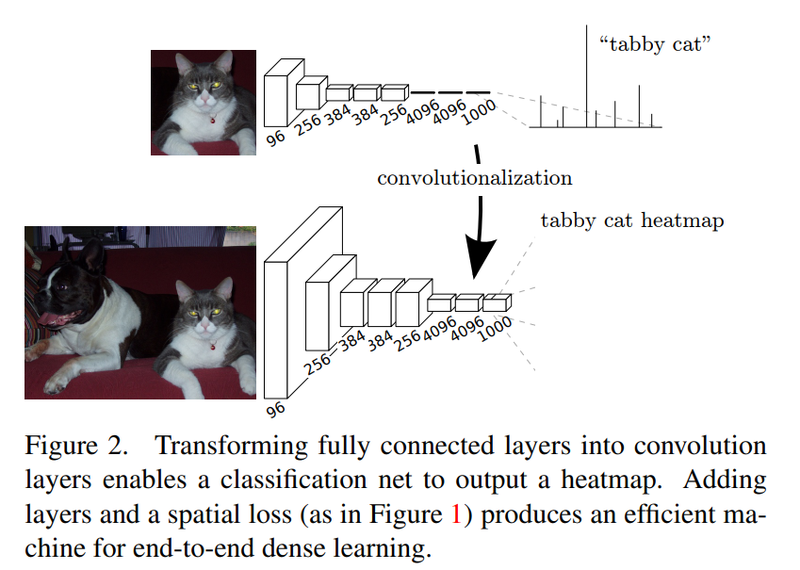

fully connected layer 대신 CNN을 붙여주는 이유는, CNN은 이미지 내 위치의 특성을 유지한다. 하지만 fully connected layer는 위치를 고려하지 않음. 위치정보를 유지하면서 클래스 단위의 히트맵을 얻어 segmentation을 하기 위해, fully connected layer를 CNN으로 대체한다.

CNN은 위치의 특성을 유지하면서 이미지 분류를 하기 위해 마지막 CNN은 1X1의 kernel size와 클래스의 개수만큼의 채널을 갖는다. 이렇게 CNN을 거치면 클래스 히트맵을 얻을 수 있다.

하지만 히트맵의 크기는 일반적으로 원본 이미지보다 작다. CNN과 pooling 레이어를 거치면서 크기가 줄었기 때문인데, 이를 키워주는 방법을 **upsampling**이라고 한다. 

upsampling에는 여러 가지 방법이 있는데, FCN은 그 중 Deconvolution과 Interpolation 방식을 활용한다. Deconvolution은 컨볼루션 연산을 거꾸로 해준 것이라고 볼 수 있고, Interpolation은 보간법으로 주어진 값들을 통해 추정해야 하는 픽셀을 추정하는 방법이다.(여기서 픽셀은 특성 맵의 크기가 커지면서 메꾸어야 하는 중간 픽셀들을 의미한다.)


## 주요 세그멘테이션 모델 (2) U-Net

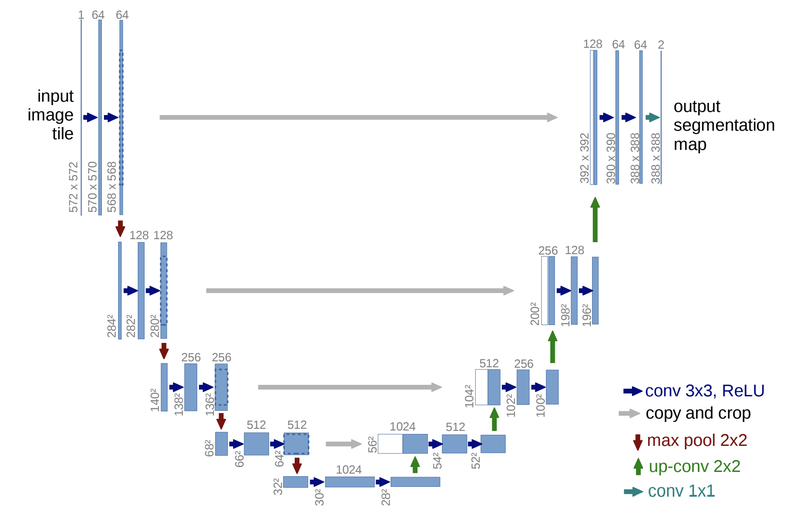

U-Net은 이름에서 볼 수 있듯이 네트워크 구조가 U 형태를 띄고 있다. FCN에서 upsampling을 통해서 특성 맵을 키운 것을 입력값과 대칭적으로 만들어 준 것이다. 

특이한 점은 U-Net이 세그멘테이션뿐만 아니라 여러 가지 이미지 태스크에서 사용되는 유명한 네트워크가 되었지만, 본래 의학 관련 논문으로 시작되었다는 점이다. 원래는 세포의 영역을 세그멘테이션하기 위해 개발된 방법이다.

* 전체 구조
  * 논문에서는 네트워크 구조를 좌측의 Contracting path와 우측의 Expansive path 두 가지로 구분한다.
  * Contracting path
    * Convolution Network와 유사한 구조를 가진다.
    * 각 블록은 두 개의 3X3 convolution 계층과 ReLU를 가지고 그 뒤로 downsampling을 위해서 2x2의 커널을 2 stride로 max pooling하게 된다.
    * downsampling을 거친 후 다음 convolution의 채널 크기는 두 배씩 늘어나도록 설계되었다.
  * Expansive path
    * 각 블록에 2x2 up-convolution이 붙어 채널이 절반씩 줄어들고 특성맵의 크기는 늘어난다.
    * Expansive path의 블록은 contracting block과 동일하게 3x3 convolution이 두 개씩 사용되었다.

> **Q. U-Net의 구조는 대칭이지만 (원 논문의 구현을 기준으로 하면) 모델의 입력값과 출력값의 크기가 다릅니다. 그 이유가 뭘까요?**
>
> A. Convolution은 padding을 통해서 크기를 같게 유지할 수 있으나, U-Net에선 padding을 하지않아서 deconvolution으로 확대하더라도 원래 이미지 크기가 될 수 없습니다.

* 타일(Tile) 기법

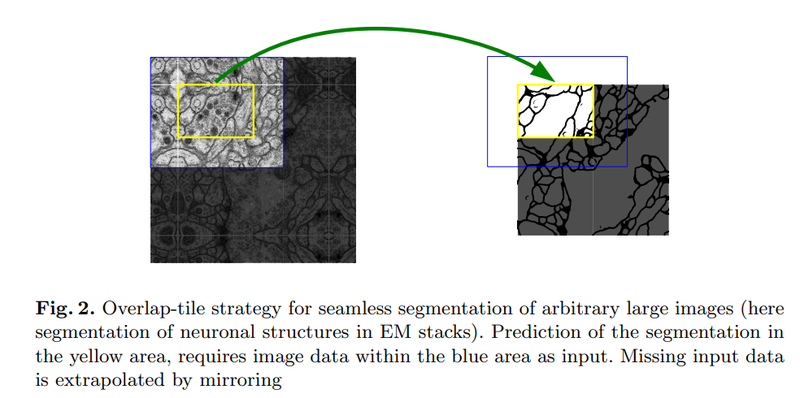

U-Net이 downsampling과 upsampling을 대칭으로 하는 점은 구조에서 한눈에 파악이 된다. 또 다른 차이는 얻을 수 있는 세그멘테이션 맵의 해상도이다. 

FCN은 입력 이미지의 크기를 조정해 세그멘테이션 맵을 얻어냈다. 반면 U-Net은 타일 방식을 사용해 어느 정도 겹치는 구간으로 타일을 나누어 네트워크를 추론, 큰 이미지에서도 높은 해상도의 세그멘테이션 맵을 얻을 수 있도록 했다.

* 데이터 불균형 해결

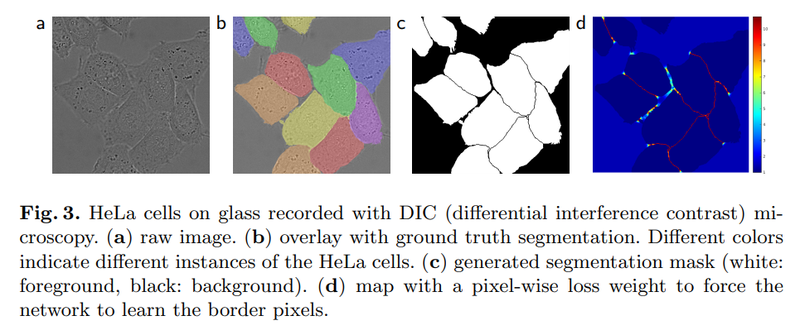

세포를 검출해 내기 위해서는 세포들의 영역뿐만 아니라 경계또한 예측을 해야 한다. 이 때 픽셀 단위로 라벨을 매긴다고 생각하면, 데이터셋에 세포나 배경보다는 절대적으로 세포 간 경계의 면적이 작을 것이다. 이러한 클래스 간 데이터 양의 불균형을 해결해 주기 위해서 분포를 고려한 weight map을 학습 때 사용했다고 한다.

단, weight map의 weight과 학습 파라미터를 가리키는 weight은 다르다. weight map에서 weigjt은 **손실 함수(loss)에 적용되는 가중치**를 말한다. 

의료 영상에서 세포 내부나 배경보다는 상대적으로 면적이 작은 세포 경계를 명확하게 추론해 내는 것이 더 중요하기 때문에, 세포 경계에 손실에 더 많은 페널티를 부과하는 방식이다.

## 주요 세그멘테이션 모델 (3) DeepLab 계열


### 전체 구조

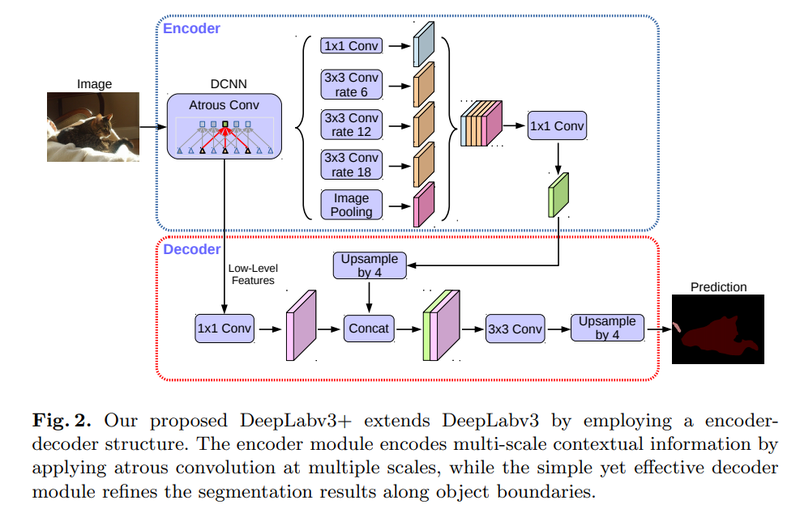

DeepLabV3+에서 인코더, 디코더는 각각 U-Net에서의 Contracting path와 Expansive path의 역할을 한다.

인코더는 이미지에서 필요한 정보를 특성으로 추출해 내는 모듈이고, 디코더는 추출된 특성을 이용해 원하는 정보를 예측하는 모듈이다. 3x3 convolution을 사용했던 U-Net과 달리 DeepLabV3+는 Arous Convolution을 사용하고 있다. 

이 Atrous Convolution을 여러 크기에 다양하게 적용한 것이 ASPP(Atrous Spatial Pyramid Pooling)이다. DeepLabV3+는 ASPP가 있는 블록을 통해 특성을 추출하고 디코더에서 Upsampling을 통해 세그멘테이션 마스크를 얻고 있다.

* Atrous Convolution

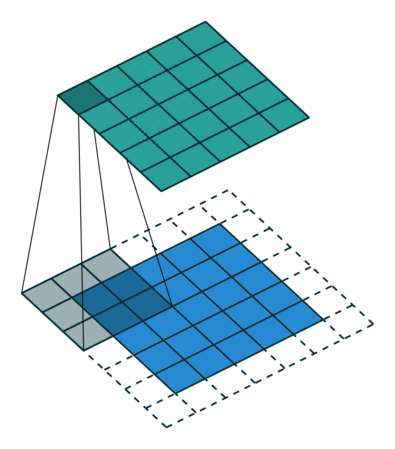

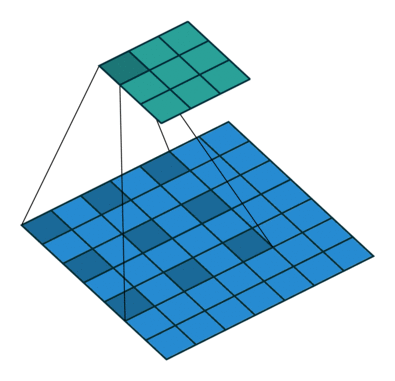

Atrous Convolution은 간단히 말하면, '띄엄띄엄 보는 컨볼루션'이다. 위 두 그림에서 아래 Atrous Convolution은 좌측의 일반적인 컨볼루션과 달리 더 넓은 영역을 보도록 해주기 위한 방법으로 커널이 일정 간격으로 떨어져 있다. 이를 통해 컨볼루션 레이어를 너무 깊이 쌓지 않아도 넓은 영역의 정보를 커버할 수 있게 된다.

> 딥러닝에서 사용되는 여러 유형의 Convolution 소개: https://zzsza.github.io/data/2018/02/23/introduction-convolution/

* Spatial Pyramid Pooling

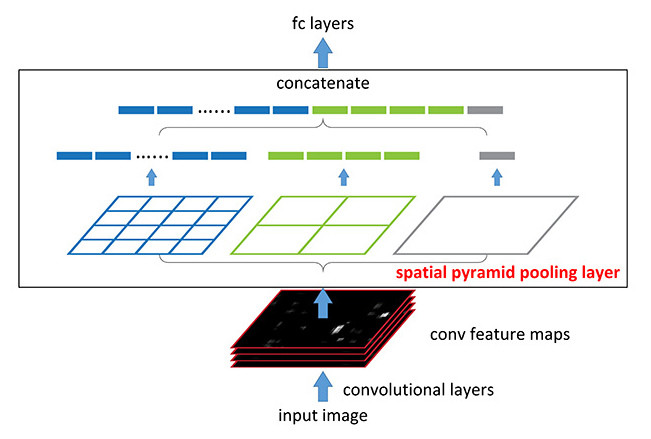

Spatial Pyramid Pooling은 여러 가지 스케일로 convolution과 pooling을 하고 나온 다양한 특성을 연결(concatenate)해 준다. 이를 통해 멀티스케일로 특성을 추출하는 것을 병렬로 수행하는 효과를 얻을 수 있다. 여기서 컨볼루션을 Atrous Convolution으로 바꾸어 적용한 것은 Atrous Spatial Pyramid Pooling이라고 한다. 이런 아키텍쳐는 입력 이미지 크기와 관계 없이 동일한 구조를 활용할 수 있다는 장점이 있다. 그러므로 제각기 다양한 크기와 비율을 가진 Rol 영역에 대해 적용하기에 유리하다.

> 참고: https://yeomko.tistory.com/14

## 세그멘테이션의 평가
일반적으로 semantic segmentation의 결과값은 이미지의 크기에 맞는 segmentation 맵 크기와 semantic segmentation 클래스 수에 맞는 채널 크기를 갖는다. 여기서 각 채널의 max probability에 따라서 해당 위치의 클래스가 결정된다.

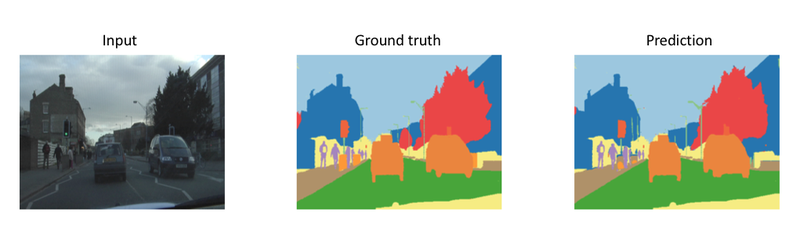

> **Q. 위에서 보이는 "Ground truth"와 "Prediction"을 어떤 방식으로 비교하여 정오 여부를 가릴 수 있을지 생각해 봅시다!**
>
> A. 픽셀의 수만큼의 분류 문제로 평가할 수 있습니다.

1. 픽셀별 정확도(Pixel Accuracy)

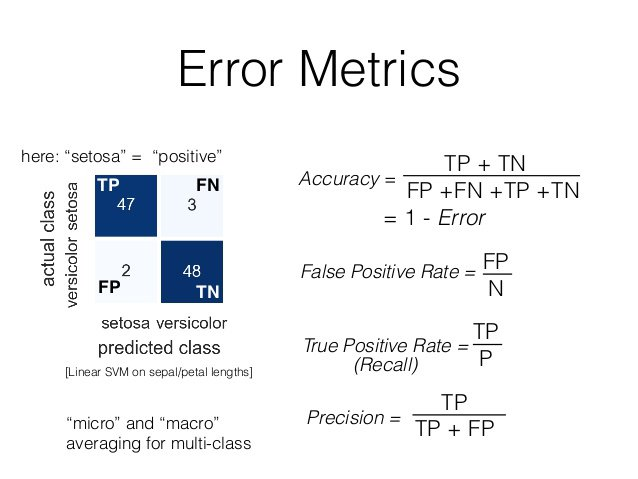

Pixel Accuracy 는 픽셀에 따른 정확도를 의미한다.

세그멘테이션 문제를 픽셀에 따른 이미지 분류 문제로 생각했을 때, 우리는 마치 이미지 분류 문제와 비슷하게 픽셀별 분류 정확도를 세그멘테이션 모델을 평가하는 기준으로 생각할 수 있다.

이때 예측 결과 맵(prediction map)을 클래스 별로 평가하는 경우에는 이진 분류 문제(binary classification)로 생각해 픽셀 및 채널 별로 평가한다. 픽셀 별 이미지 분류 문제로 평가하는 경우에는 픽셀 별로 정답 클래스를 맞추었는지 여부, 즉 True/False를 구분한다.

> 본문 그대로 옮김.
> 
> 예를 들어, 4x4의 크기를 가지는 map에서 중앙의 2x2의 영역이 전경이고 예측 결과 중 한 칸을 놓쳤습니다. 이때는 위에서 보이는 Error Metrics를 확인하면 (TP+TN)/(FP+FN+TP+TN)으로 Accuracy를 구할 수 있습니다. TP(True positive)+ TN(True negative)는 옳게 분류된 샘플의 수로 잘못 예측된 한 칸을 제외한 15입니다. 그리고 False case는 1인 한 칸은 전경이 배경으로 예측되었으니 FN(False negative)입니다. 따라서 분모항은 16이 됩니다. 따라서 Pixel Accuracy는 15/16으로 계산할 수 있습니다.

2. 마스크 IoU(Mask Intersection-over-Union)
물체 검출 모델을 평가할 땐 정답 라벨(ground truth)와 예측 결과 바운딩 박스(prediction bounding box) 사이의 IoU(Intersection over Union)를 사용한다. 마스크도 일종의 영역임을 생각했을 때, 세그멘테이션 문제에서는 정답인 영역과 예측한 영역의 IoU를 계산할 수 있을 것이다. 아래 식처럼 세그멘테이션 마스크의 IoU는 생각보다 쉽게 계산할 수 있다.



In [ ]:
# sample for mask iou
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)

마스크 IoU를 클래스 별로 계산하면 한 이미지에서 여러 클래스에 대한 IoU 점수를 얻을 수 있다. 이를 평균하면 전체적인 semantic segmentation 성능을 가늠할 수 있다. 

## Upsampling의 다양한 방법
Convolution Layer와 다양한 Pooling 등으로 Feature의 크기를 줄여왔는데, 반대로 키우는 방법에는 어떤 것들이 있을까?
1. Nearest Neighbor

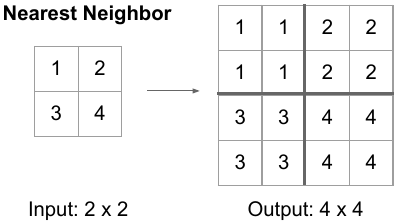

Nearest upsampling은 이름 그대로 scale을 키운 위치에서 원본에서 가장 가까운 값을 그대로 적용하는 방법이다. 위 그림처럼 2x2 matrix가 있을 때, 이를 2배로 키우면 4x4의 matrix가 된다. 이때 좌측 상단으로부터 2x2는 입력 matrix의 1x1과 가장 가깝다. 따라서 해당 값을 그대로 사용하게 된다.

2. Bilinear Interpolation

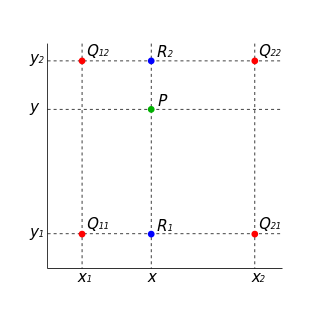

Bilinear Interpolation은 두 축에 대해서 선형 보간법을 통해 필요한 값을 메우는 방식이다. 2x2 matrix를 4x4로 upsampling을 할 때 위의 이미지처럼 빈 값들을 채워야한다. 이에 선형보간법(Linear interpolation)을 사용하는 것인데, 이 떄 축을 두 방향으로 활용하기 때문에 Bilinear interpolation이라고 한다.

위 그림에서 두 가지 interpolation을 적용한 것을 순서대로 확인할 수 있는데, R1이 Q11과 Q21의 x축 방향의 interpolation 결과이다. 그리고 R2는 Q12와 Q22의 x축 방향의 interpolation 결과이다. 그리고 R1과 R2를 y축 방향으로 interpolation하면 새로운 위치 P의 값을 추정할 수 있다. 이러한 선형 보간 방법으로 interpolation을 하는 방법이 있고 Bicubic interpolation의 경우 삼차보간법을 사용한다.

> 참고: https://bskyvision.com/m/789

3. Transposed Convolution

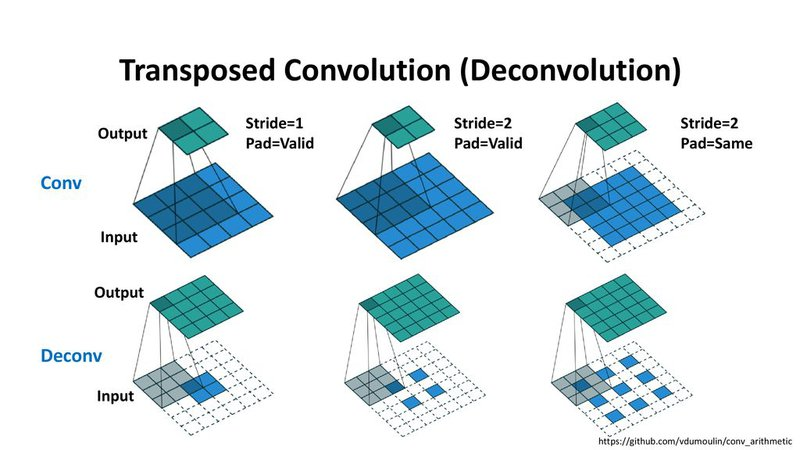

학습할 수 있는 파라미터를 가진 Upsampling 방법 중 하나이다. 우리가 사용해왔던 Convolution Layer는 Kernel의 크기를 정의하고 입력된 Feature를 window에 따라서 output을 계산한다.

Transposed Convolution은 이와 반대의 연산을 한다. 따라서 거꾸로 학습된 파라미터로 입력된 벡터를 통해 더 넓은 영역의 값을 추정해낸다. 

> 자세한 설명: https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/